In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, Callback
import psutil
import time
import GPUtil
import matplotlib.pyplot as plt

In [3]:
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "../dataset/training_set",
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "../dataset/test_set",
    image_size=img_size,
    batch_size=batch_size
)


Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [5]:
def get_cpu_ram():
    cpu_percent = psutil.cpu_percent(interval=1)
    ram = psutil.virtual_memory()
    ram_used_mb = ram.used / (1024 ** 2)
    return cpu_percent, ram_used_mb
def get_gpu_stats():

    try:
        gpus = GPUtil.getGPUs()
        if not gpus:
            return None, None, None
        gpu = gpus[0]
        return gpu.load * 100, gpu.memoryUsed, gpu.memoryTotal
    except:
        return None, None, None


In [6]:
cpu_before, ram_before = get_cpu_ram()
gpu_before, vram_used_before, vram_total_before = get_gpu_stats()

msg = f"AVANT entraînement -> CPU: {cpu_before:.1f}% | RAM: {ram_before:.0f} MB"
if gpu_before is not None:
    msg += f" | GPU: {gpu_before:.1f}% | VRAM: {vram_used_before}/{vram_total_before} MB"
print(msg)


AVANT entraînement → CPU: 7.4% | RAM: 5724 MB | GPU: 0.0% | VRAM: 0.0/4096.0 MB


In [7]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  

In [8]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

In [9]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [10]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

class PerformanceCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        cpu, ram = get_cpu_ram()
        gpu, vram_used, vram_total = get_gpu_stats()
        duration = time.time() - self.start_time

        msg = f" | CPU: {cpu:.1f}% | RAM: {ram:.0f} MB | Time: {duration:.1f}s"
        if gpu is not None:
            msg += f" | GPU: {gpu:.1f}% | VRAM: {vram_used}/{vram_total} MB"
        print(msg)



In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, PerformanceCallback()]
)


Epoch 1/10
250/250 [==============================] - 181s 712ms/step - loss: 0.6161 - accuracy: 0.6661 - val_loss: 0.5407 - val_accuracy: 0.7445
Epoch 2/10
250/250 [==============================] - 157s 629ms/step - loss: 0.5464 - accuracy: 0.7235 - val_loss: 0.5292 - val_accuracy: 0.7365
Epoch 3/10
250/250 [==============================] - 158s 632ms/step - loss: 0.5264 - accuracy: 0.7339 - val_loss: 0.5385 - val_accuracy: 0.7180
Epoch 4/10
250/250 [==============================] - 156s 626ms/step - loss: 0.5025 - accuracy: 0.7491 - val_loss: 0.5042 - val_accuracy: 0.7585
Epoch 5/10
250/250 [==============================] - 156s 623ms/step - loss: 0.4913 - accuracy: 0.7573 - val_loss: 0.4962 - val_accuracy: 0.7565
Epoch 6/10
250/250 [==============================] - 157s 626ms/step - loss: 0.4817 - accuracy: 0.7655 - val_loss: 0.4918 - val_accuracy: 0.7615
Epoch 7/10
250/250 [==============================] - 161s 645ms/step - loss: 0.4723 - accuracy: 0.7700 - val_loss: 0.4880 -

In [12]:
cpu_after, ram_after = get_cpu_ram()
gpu_after, vram_used_after, vram_total_after = get_gpu_stats()

msg = f"APRÈS entraînement -> CPU: {cpu_after:.1f}% | RAM: {ram_after:.0f} MB"
if gpu_after is not None:
    msg += f" | GPU: {gpu_after:.1f}% | VRAM: {vram_used_after}/{vram_total_after} MB"
print(msg)


APRÈS entraînement -> CPU: 4.6% | RAM: 5551 MB | GPU: 1.0% | VRAM: 0.0/4096.0 MB


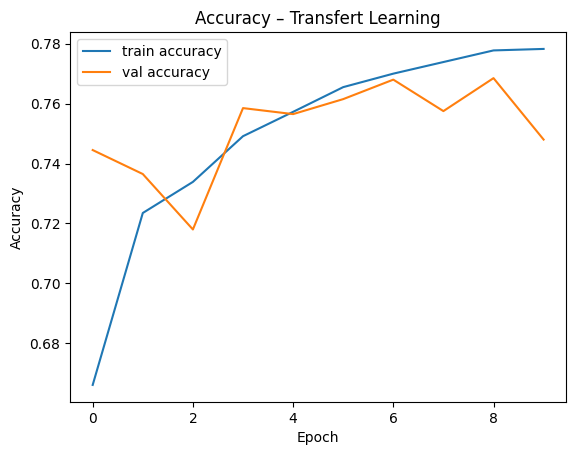

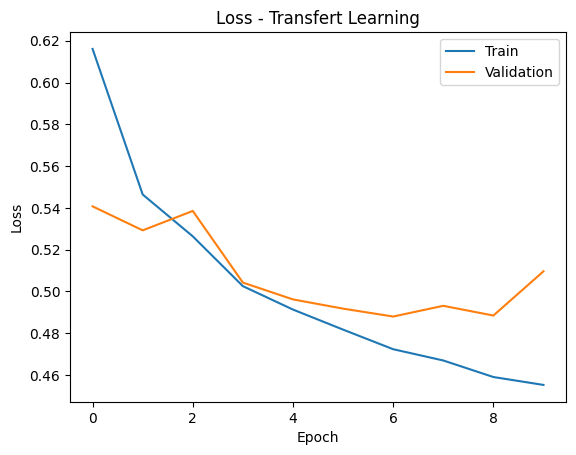

In [16]:
plt.figure()
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy – Transfert Learning")
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.title("Loss - Transfert Learning")
plt.show()

### Conclusion
Les courbes de loss et d’accuracy montrent une convergence rapide du modèle, avec une amélioration nette des performances dès les premières epochs. La loss de validation diminue de manière régulière et l’accuracy atteint rapidement un niveau élevé, tandis que l’écart entre entraînement et validation reste limité, indiquant une bonne généralisation et l’absence de surapprentissage significatif.

Le suivi du temps d’entraînement par epoch met en évidence un coût computationnel important lié à l’exécution sur CPU, mais stable tout au long de l’apprentissage. La matrice de confusion confirme que la majorité des images sont correctement classées, avec quelques erreurs résiduelles liées à des images ambiguës. Ces résultats montrent que le transfert learning est particulièrement adapté au problème Dogs & Cats, permettant d’obtenir de très bonnes performances avec un effort d’entraînement limité.